<a href="https://colab.research.google.com/github/cultures/test/blob/master/2_Clustering_Climate_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Tutorial
*By Caleb Robinson, Amrita Gupta, and Aaron Ferber*

Let's take a look at clustering geographic locations based on their climate data. This work is based on the paper *Representativeness-based sampling network design for the State of Alaska* which you can find here https://www.fs.usda.gov/treesearch/pubs/45097.

**The Problem**:

It is very important (but difficult and expensive) to monitor sparse data about the arctic as a whole. Bottlenecks include but are not limited to: funding, remote nature, freezing temperatures, terrain difficulty, etc. 

**Idea**:

Let's delineate which regions are similar so that we can get highly representatitve information under our constraints.


## Install Packages

In [0]:
!pip install rasterio

## Data

### "Current" Climate Data

WorldClim 1.4 - http://www.worldclim.org/current

Averaged from ~1960-1990.

We are using the 10 minute spatial resolution. See [here](http://www.longitudestore.com/how-big-is-one-gps-degree.html) for what that means (each grid cell is ~18km^2).

Note, we are _not_ using the WorldClim 2.0 data because the projected climate data is calibrated to WorldClim 1.4.

### Projected Climate Data

WorldClim 1.4 CMIP5 Projections - http://www.worldclim.org/cmip5_10m

See RCP information [here](https://en.wikipedia.org/wiki/Representative_Concentration_Pathway).

### What the variables actually are

The 19 "bioclimatic" variables we are using are described  [here](http://www.worldclim.org/bioclim).

- BIO1 = Annual Mean Temperature
- BIO2 = Mean Diurnal Range (Mean of monthly (max temp - min temp))
- BIO3 = Isothermality (BIO2/BIO7) (* 100)
- BIO4 = Temperature Seasonality (standard deviation *100)
- BIO5 = Max Temperature of Warmest Month
- BIO6 = Min Temperature of Coldest Month
- BIO7 = Temperature Annual Range (BIO5-BIO6)
- BIO8 = Mean Temperature of Wettest Quarter
- BIO9 = Mean Temperature of Driest Quarter
- BIO10 = Mean Temperature of Warmest Quarter
- BIO11 = Mean Temperature of Coldest Quarter
- BIO12 = Annual Precipitation
- BIO13 = Precipitation of Wettest Month
- BIO14 = Precipitation of Driest Month
- BIO15 = Precipitation Seasonality (Coefficient of Variation)
- BIO16 = Precipitation of Wettest Quarter
- BIO17 = Precipitation of Driest Quarter
- BIO18 = Precipitation of Warmest Quarter
- BIO19 = Precipitation of Coldest Quarter

Let's download some relevant data from here: https://data.biogeo.ucdavis.edu/


*   current bioinformatic features (version 1.4 not 2.0): http://worldclim.org/version1
*   bioinformatic projections for 2070 with several models under several greenhouse gas scenarios: http://worldclim.org/cmip5_10m

### Download and unzip data
if it hasn't changed, we don't redownload the data (-N flag) and we run it in quiet mode with q

In [0]:
!wget -Nq http://biogeo.ucdavis.edu/data/climate/worldclim/1_4/grid/cur/bio_10m_esri.zip

!wget -Nq http://biogeo.ucdavis.edu/data/climate/cmip5/10m/bc85bi50.zip
!wget -Nq http://biogeo.ucdavis.edu/data/climate/cmip5/10m/bc26bi50.zip
  
!unzip -nq bio_10m_esri.zip
!unzip -nq bc85bi50.zip -d projection_data
!unzip -nq bc26bi50.zip -d projection_data

## Reading Data and Preliminary Analysis

In [0]:
%matplotlib inline
import os             # do cross platform manipulation of filesystem

import numpy as np    # matrix library
import scipy
import scipy.spatial  # for distance calculations

import rasterio       # read in and handle rasters

import matplotlib     # plotting library
import matplotlib.pyplot as plt

import seaborn as sns # plotting library expansion

from sklearn import cluster # clustering package from machine learning library
from sklearn import preprocessing  # for preprocessing and storing data transformations
from sklearn import metrics # for quantitatively evaluating our ml models
from scipy import stats     # statistics library for describing data

Here we write out the 19 feature names as described here: http://www.worldclim.org/bioclim

We can get the relevant file names for each of the 1-19 features and store them in a list for the **current** bioindicators and the **future** indicators (according to the BCC-CSM1-1 model assuming greenhouse gas concentrations follow the rcp 8.5 projections)

In [0]:
# ordered list of feature names found here: http://www.worldclim.org/bioclim
feature_names = [
  'Annual Mean Temperature',
  'Mean Diurnal Range (Mean of monthly (max temp - min temp))',
  'Isothermality (BIO2/BIO7) (* 100)',
  'Temperature Seasonality (standard deviation *100)',
  'Max Temperature of Warmest Month',
  'Min Temperature of Coldest Month',
  'Temperature Annual Range (BIO5-BIO6)',
  'Mean Temperature of Wettest Quarter',
  'Mean Temperature of Driest Quarter',
  'Mean Temperature of Warmest Quarter',
  'Mean Temperature of Coldest Quarter',
  'Annual Precipitation',
  'Precipitation of Wettest Month',
  'Precipitation of Driest Month',
  'Precipitation Seasonality (Coefficient of Variation)',
  'Precipitation of Wettest Quarter',
  'Precipitation of Driest Quarter',
  'Precipitation of Warmest Quarter',
  'Precipitation of Coldest Quarter'
]

# format strings that map us to the files we want
# using os.path.join to get platform independent paths
current_feat_file_name_fmt = os.path.join("bio","bio_{feat_ind}","hdr.adf")
future_feat_file_name_fmt = os.path.join("projection_data","{model}{feat_ind}.tif")

model_names = ["bc26bi50","bc85bi50"]

current_filenames = [current_feat_file_name_fmt.format(feat_ind=feat_ind) 
                     for feat_ind in range(1, len(feature_names)+1)]

# dictionary (hashtable) mapping a model name to a list of feature names
# we can look up the feature names for a given model name by doing
# future_filenames["model"], take a look at 
# future_filenames.keys() to see what models there are
future_filenames = {model:
                    [future_feat_file_name_fmt.format(model=model, feat_ind=feat_ind)
                           for feat_ind in range(1, len(feature_names)+1)]
                    for model in model_names}

### Helper Functions

In [0]:
def load_features(file_names):
  """Load masked rasters from a list of filenames
  
  loads all the data in the given input filenames and masks away any square 
  in the raster that does not have an observation for "all" of the features
  
  Args:
      file_names (str list) : List of filenames from which to read individual 
        features
      
  Returns:
      data (numpy masked array) : numpy matrix excluding entries with no data
        in any feature
  """
  
  mask = None
  raw_data = []
  for file_name in file_names:    
    # open raster for reading the raw data
    with rasterio.open(file_name, "r") as f:
      data = f.read().squeeze().astype(np.float32)
    raw_data.append(data)
    if mask is None:
      mask = (data == f.nodata)
    else:
      mask = mask | (data == f.nodata)
  
  # mask away cells for which we have no data
  data = np.ma.array(np.stack(raw_data, axis=-1), 
                     mask=np.repeat(mask[:,:,None],len(file_names), axis=-1))
  
  return data

In [0]:
def show_map(data, title=None):
  """plots data for a scalar map
  
  Args:
      data (numpy array) : raster of values to plot
  """
  plt.figure(figsize=(10,7))
  plt.imshow(data, cmap="Blues")
  plt.colorbar(fraction=0.03, pad=0.04)
  plt.grid("off")
  if title is not None:
    plt.title(title, fontsize=16)
  plt.show()
  plt.close()

In [0]:
def show_diff_map(data, title=None):
  """plots data for a difference map
  
  create the figure from the difference data, 
  rescaling the differences appropriately. Also add relevant titles/colorbar
  and disable grid
  
  Args:
      data (numpy array) : raster of differences to plot
  """
  max_val = np.absolute(data).max()
  
  plt.figure(figsize=(10,7))
  plt.imshow(data, cmap="bwr", vmin=-max_val, vmax=max_val)
  plt.colorbar(fraction=0.03, pad=0.04)
  plt.grid("off")
  if title is not None:
    plt.title(title, fontsize=16)
  plt.show()
  plt.close()

### Load the Data
Here we need to load the current data and create a dictionary storing the future data for the different models

In [0]:
current_features = load_features(current_filenames)
projected_features = {model: load_features(model_files)
                      for model, model_files in future_filenames.items()}

# create an empty raster with the same size and mask to plot useful things later
empty_raster = np.ma.array(np.zeros_like(current_features[:,:,0]),
                           mask=current_features.mask[:,:,0])

As a sanity check, let's print out the sizes of the loaded datasets, count the number of unmasked entries (where we have data) and see how much data is missing

In [0]:
def short_data_description(data):
  print("\tshape", data.shape)
  print("\tunmasked entries:", data.count())
  print("\tmissing data:", np.prod(data.shape) - data.count())

In [0]:
print("current data")
short_data_description(current_features)
for model, data in projected_features.items():
  print(model)
  short_data_description(data)

current data
	shape (900, 2160, 19)
	unmasked entries: 11105899
	missing data: 25830101
bc26bi50
	shape (900, 2160, 19)
	unmasked entries: 11105899
	missing data: 25830101
bc85bi50
	shape (900, 2160, 19)
	unmasked entries: 11105899
	missing data: 25830101


#### Reshape Data for ML
Here let's postprocess the data so that we can get each square entry to be a row.
It will be in the form of (n_observations x n_features). This will allow us to treat each square as a different "observation" for our machine learning models

In [0]:
def flatten_mask(data):
  return data[~data.mask[:,:,0],:]

In [0]:
current_observations = flatten_mask(current_features)
projected_observations = {model: flatten_mask(projected_features[model])
                      for model, model_files in future_filenames.items()}

In [0]:
print("current indicators shape:",current_observations.shape)
print("best case scenario shape:",projected_observations["bc26bi50"].shape)

current indicators shape: (584521, 19)
best case scenario shape: (584521, 19)


### Visualize Features

#### Geospatial visualization

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


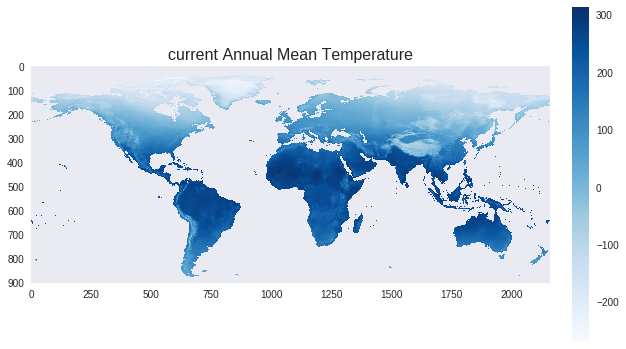

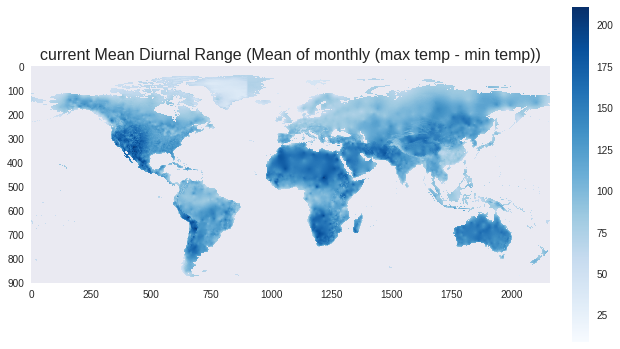

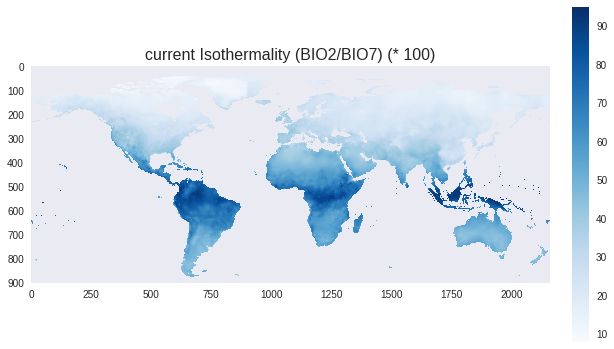

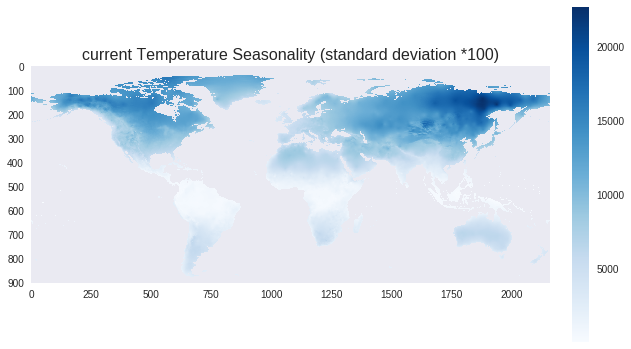

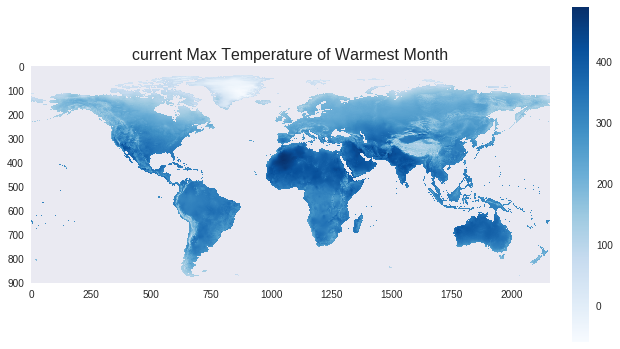

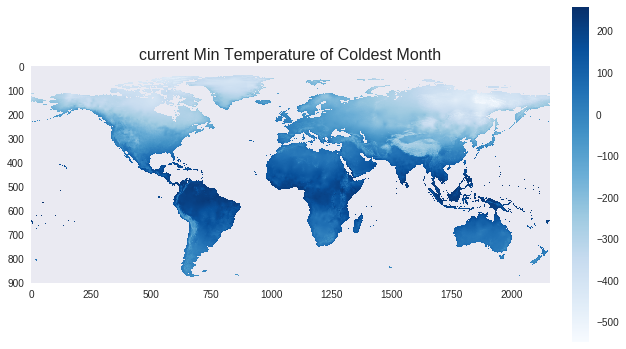

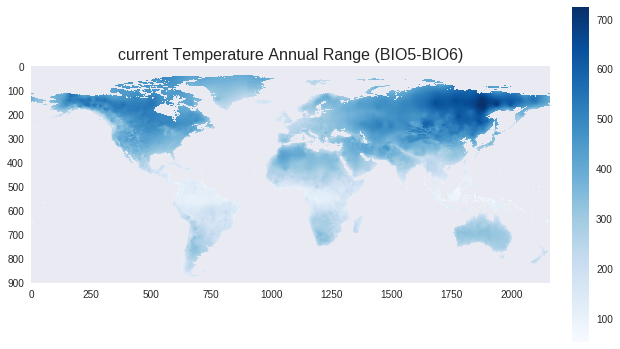

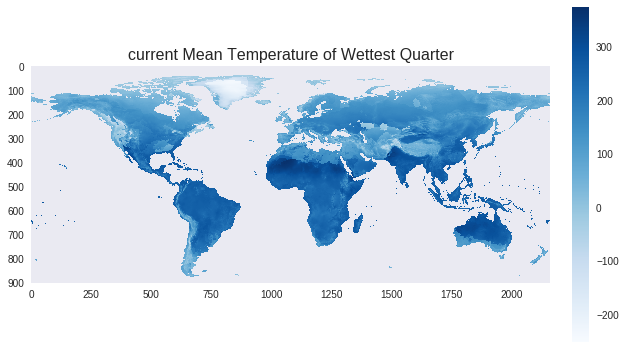

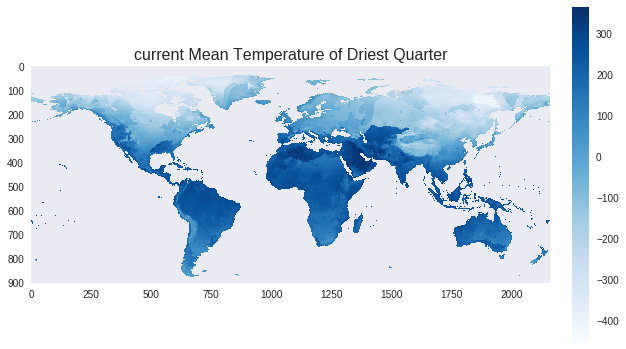

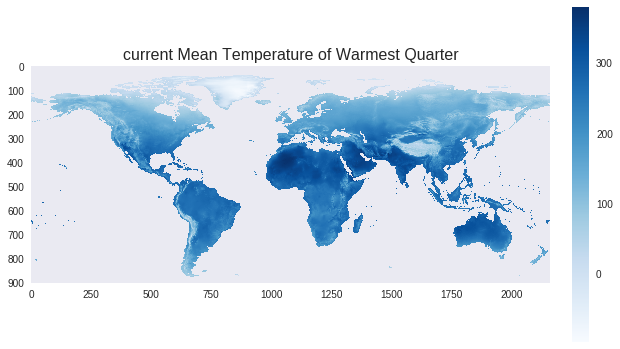

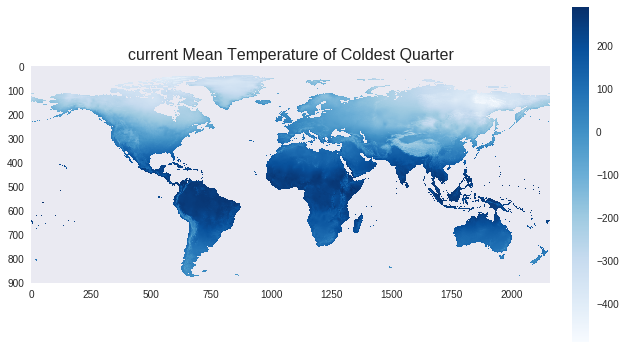

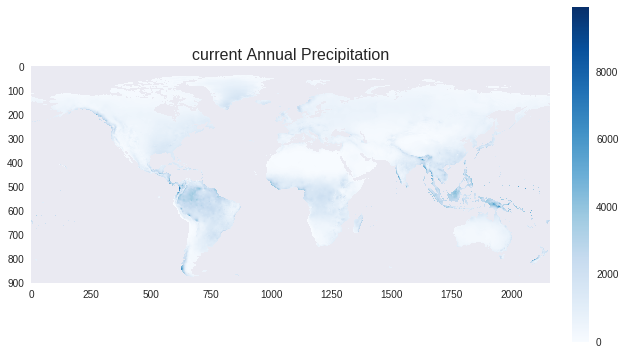

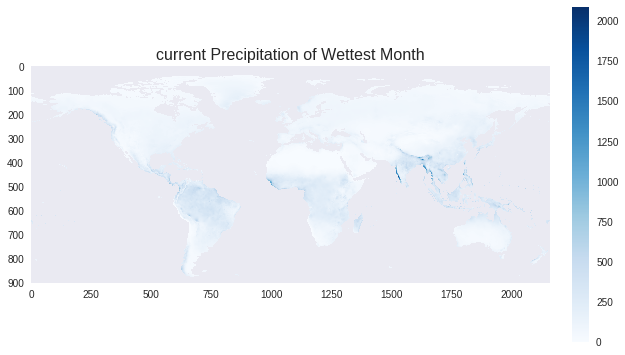

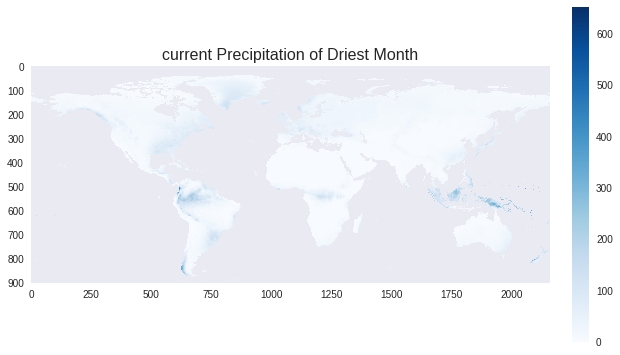

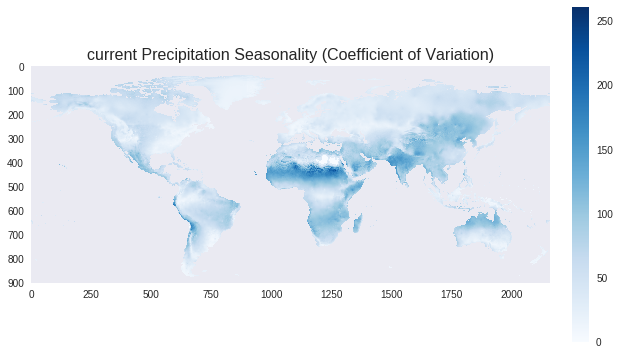

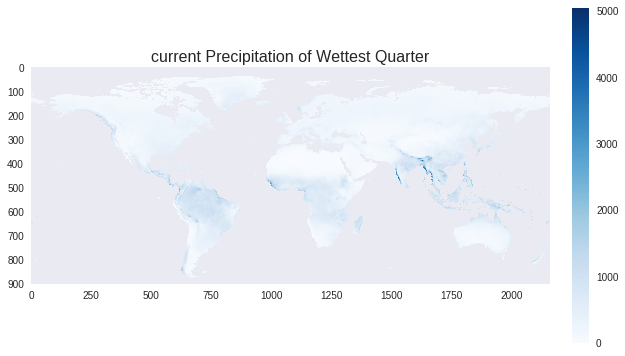

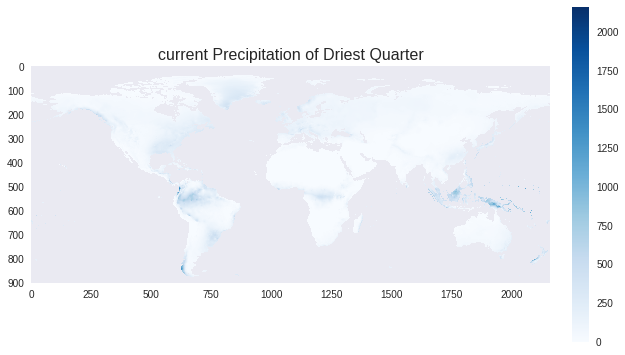

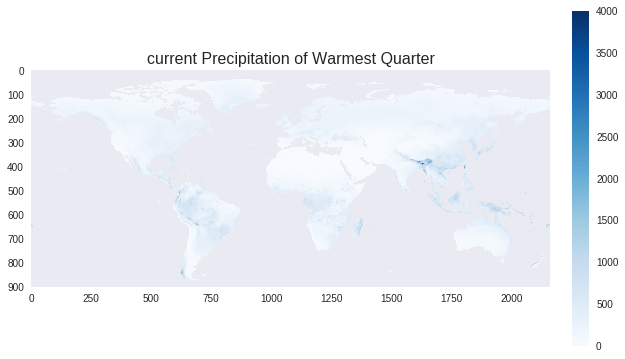

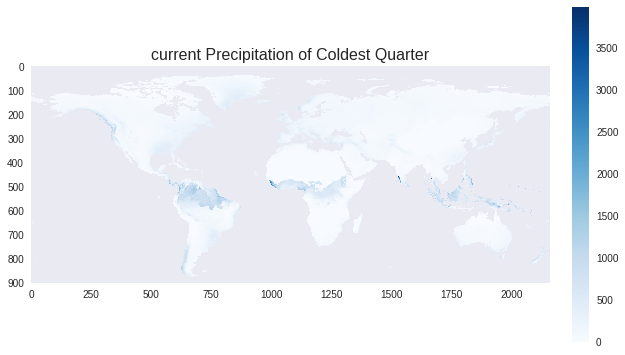

In [0]:
for i, feature_name in enumerate(feature_names):
  show_map(current_features[:,:,i], title="current {}".format(feature_name))

#### Feature Histograms

As seen in the below histograms, some of the features appear to have a large tail indicating that either we have outliers (unlikely b/c there is no clear cutoff), or are distributed differently. Let's record which features have this property so that we can optionally take the log of these features.

The features are:

11,12,13,14,15,16,17,18

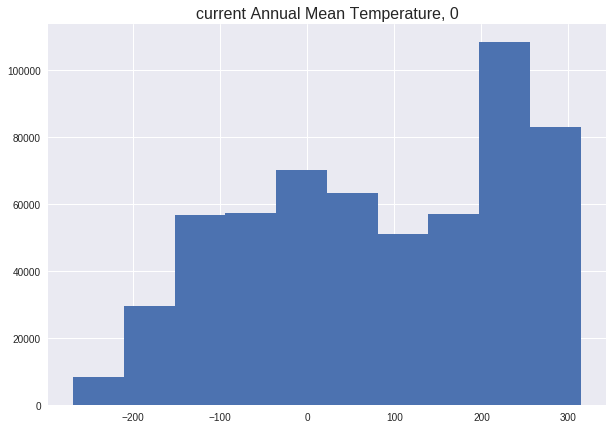

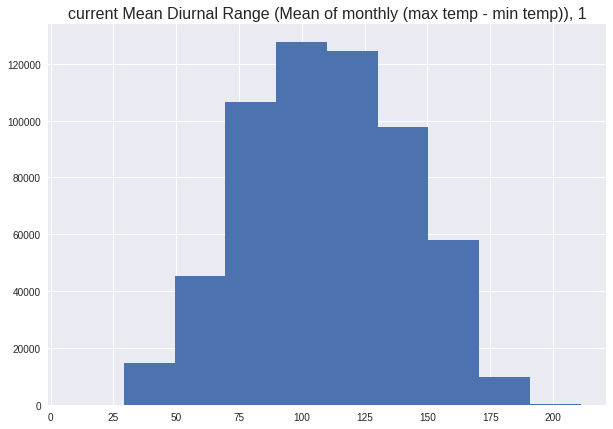

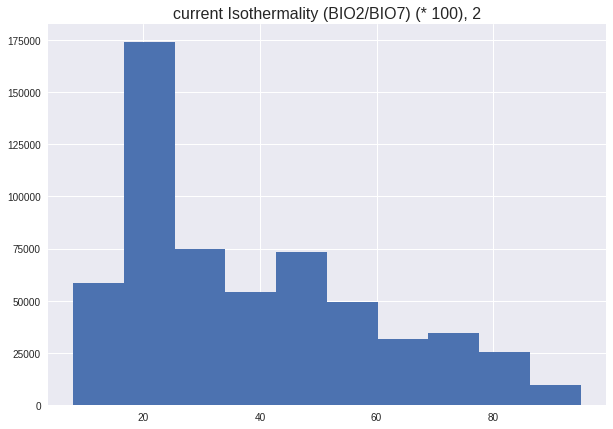

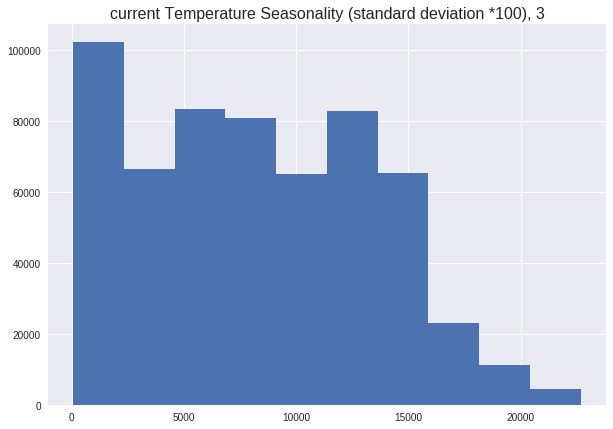

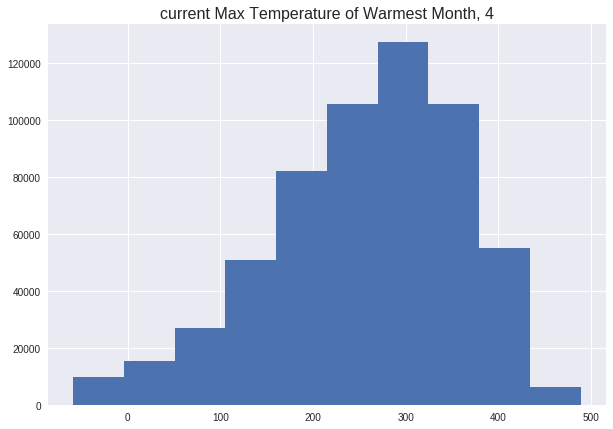

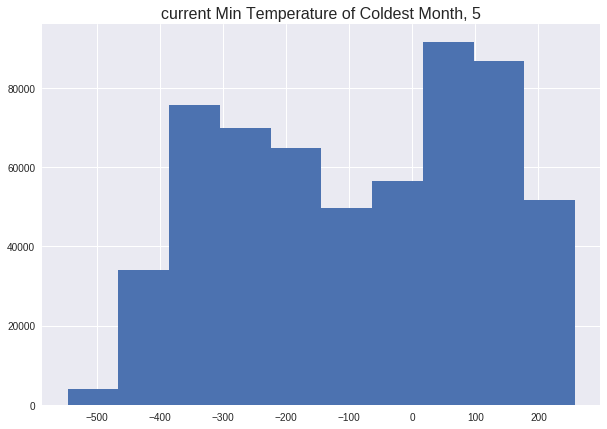

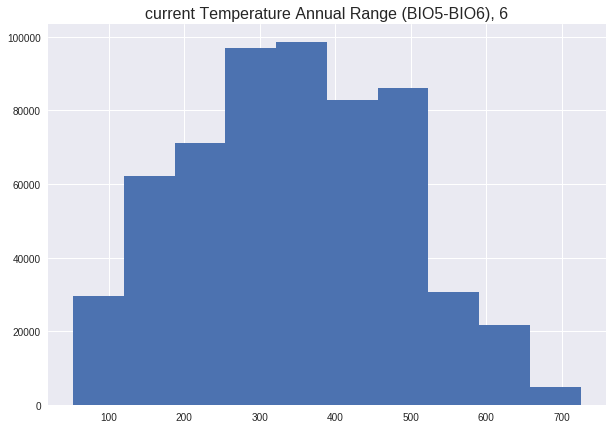

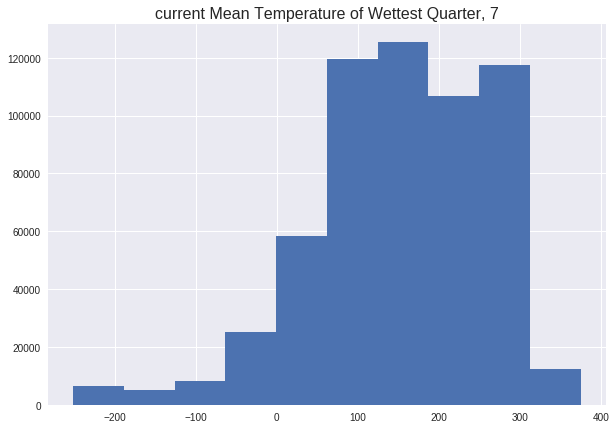

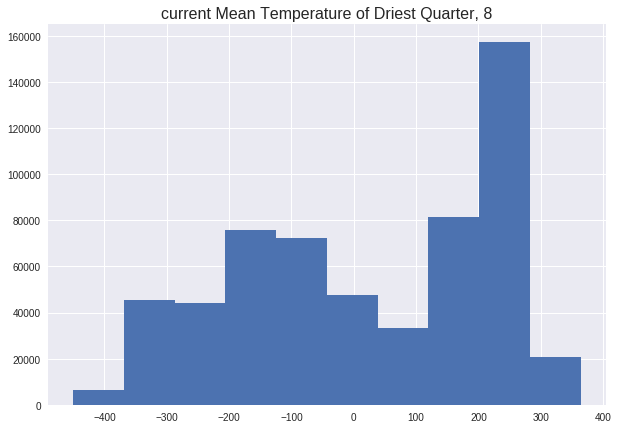

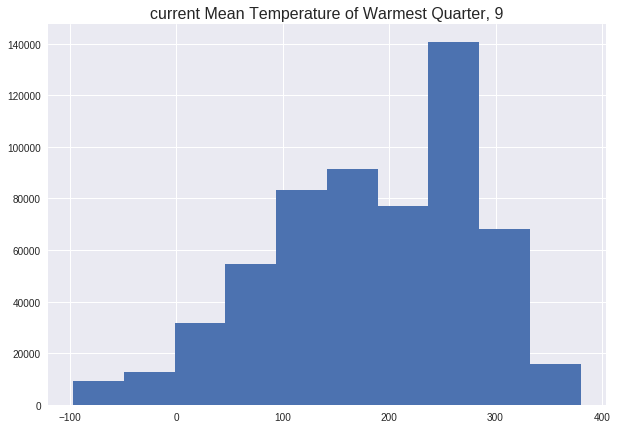

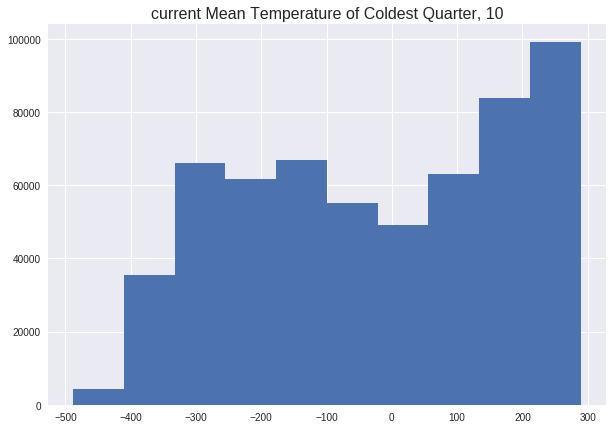

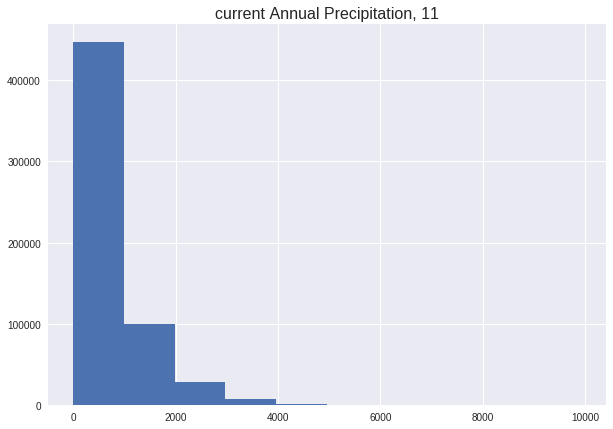

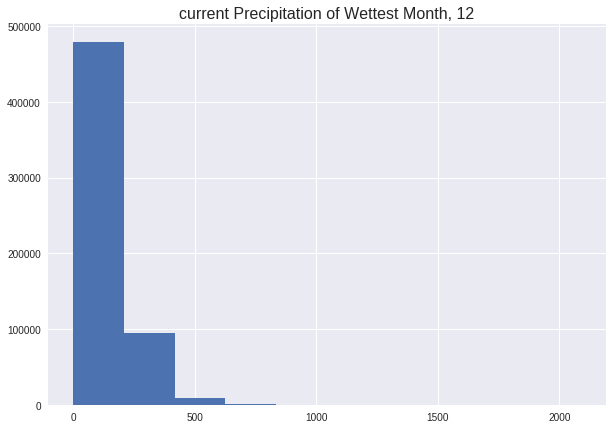

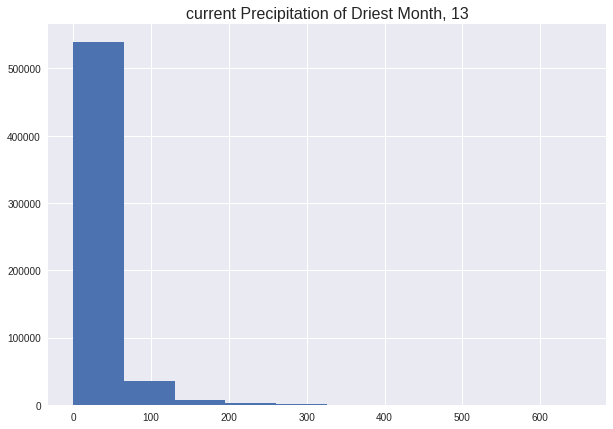

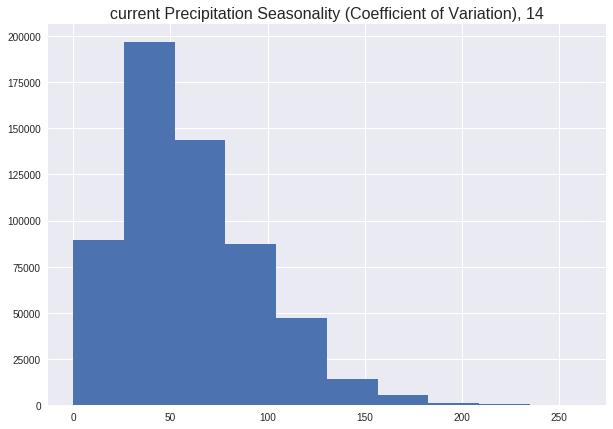

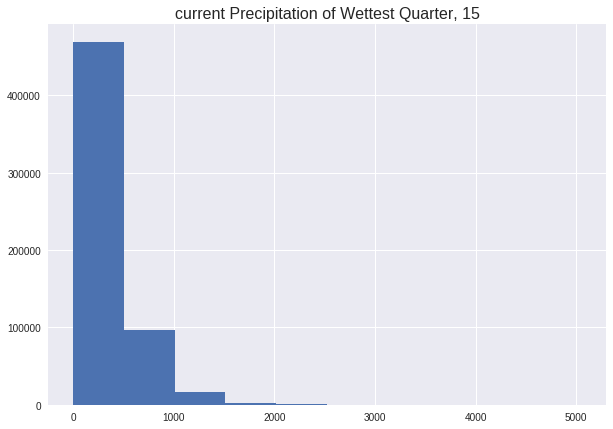

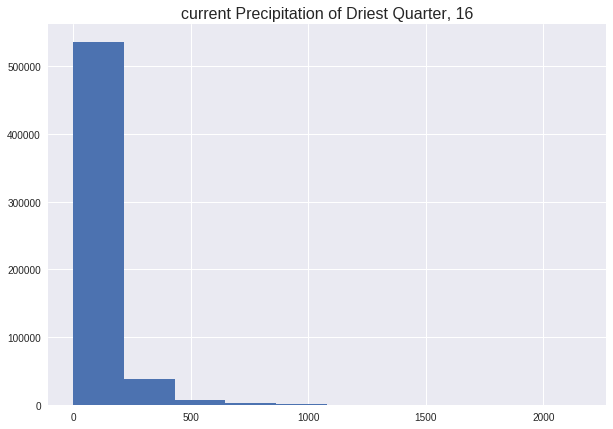

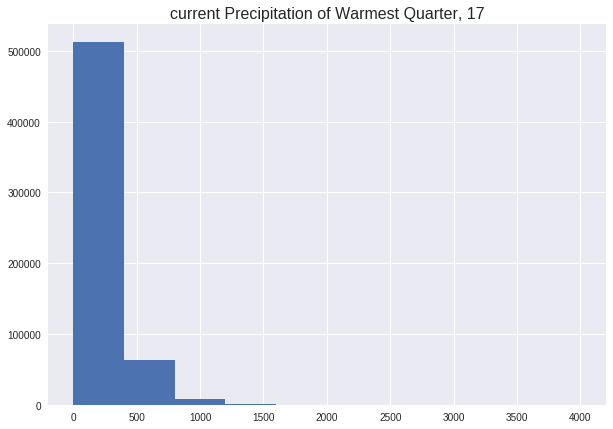

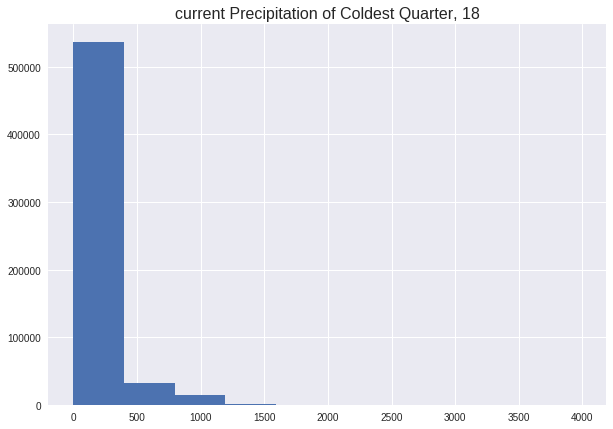

In [0]:
for i in range(19):
  plt.figure(figsize=(10,7))
  plt.hist(current_observations[:,i])
  plt.title("current {}, {}".format(feature_names[i], i), fontsize=16)

### Generate Preprocessing Steps

#### Log Transform
We can use the sklearn preprocessing library to define how to manipulate data. Here we can specify how to take the log of the data as well as how to turn it back to its original form.

In [0]:
def log_preprocess(data, log_features=None):
  res = data.copy()
  if log_features is not None:
    res[:,log_features] = np.log(res[:,log_features] + 1)
  return res

In [0]:
def log_inv(data, log_features=None):
  res = data.copy()
  if log_features is not None:
    res[:,log_features] = np.exp(res[:log_features]) - 1
  return res

In [0]:
log_features = None
log_features = [11,12,13,14,15,16,17,18]

log_transform = preprocessing.FunctionTransformer(func=log_preprocess,
                                         inverse_func=log_inv, 
                                         kw_args={"log_features":log_features},
                                         check_inverse=False)

#### Standard Scaler Transform
We want to normalize the data here so that each feature has a mean of 0 and a standard deviation of 1. This can be easily done through the sklearn standard scaler explained here: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

Again, it enables us to map the data forwards as well as backwards, maintaining the means that we subtract and the standard deviation. 

In [0]:
scaler = preprocessing.StandardScaler(copy=True)

### Preprocess Data

In [0]:
processed_current_observations = scaler.fit_transform(
    current_observations)
processed_projections = {model: 
                         scaler.transform(
                             model_observations)
                      for model, model_observations in projected_observations.items()}

Let's print out the statistics of our features so that we can see what's going on

In [0]:
print("means:",processed_current_observations.mean(axis=0))
print("means:",processed_projections["bc26bi50"].mean(axis=0))
print("stds:",processed_current_observations.std(axis=0))
print("stds:",processed_projections["bc26bi50"].std(axis=0))

means: [ 6.7517999e-07  6.2027822e-05  3.9809415e-04  5.5498913e-06
 -1.8561910e-05 -1.8902361e-06 -1.0230587e-04  2.7446629e-05
  1.5252836e-06 -1.3719647e-05 -2.5351090e-05 -6.1985215e-06
  1.2189684e-05  6.3616848e-05 -2.4034623e-05  3.5495323e-05
 -2.5612371e-05  4.6262936e-05  8.4913527e-06]
means: [ 0.12910976 -0.03547029 -0.01041434 -0.04237761  0.1607093   0.10532261
 -0.0325329   0.12034579  0.12942302  0.17037086  0.10673421  0.04642477
  0.09841085 -0.03050028  0.00374657  0.06505112  0.00322489  0.02910184
  0.0462377 ]
stds: [1.0001583  1.0001204  0.99961144 0.99993426 0.9998151  0.99976563
 1.0000684  0.9997748  0.9999478  1.0003203  1.0000774  0.9999855
 0.9999336  0.99958205 0.999916   0.9999061  1.0004274  1.0000825
 0.9999786 ]
stds: [0.9691765  1.0562257  0.9938899  0.958121   1.0213673  0.9694838
 0.9717306  1.0297443  0.96367866 1.0069094  0.966685   1.0311289
 1.117384   0.9135722  0.9387312  1.0711873  0.9765884  1.0159047
 1.0621321 ]


Looks like our current data has mean 0 and std 1 on each feature. Our projected data doesnt have mean 0 std 1 since we used the same scaling on the current observations as on the projections. This is normally done for train/test splits since we don't want the testing data to have any transformation information that is not available during training (like the mean and std of the test features). Again we can plot some histograms so that we can check in on what the distributions look like

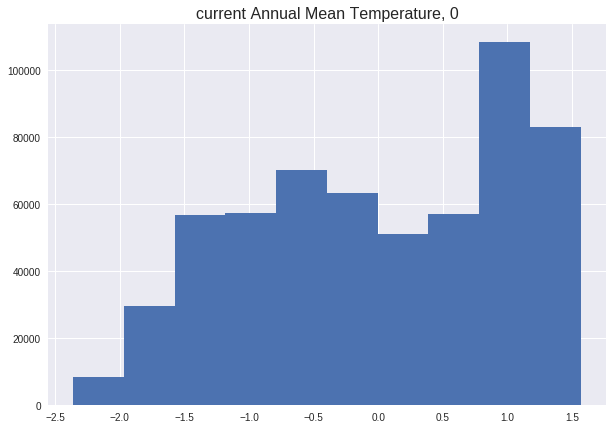

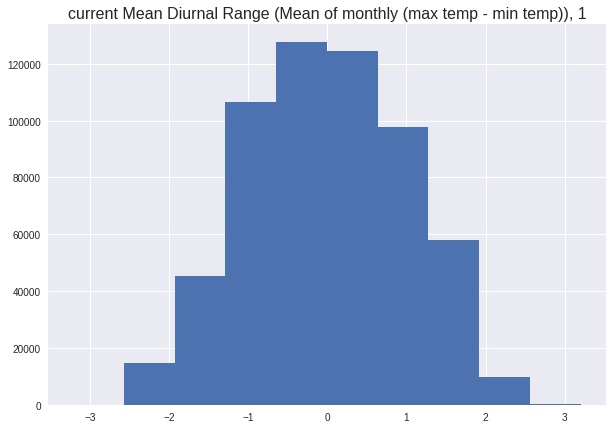

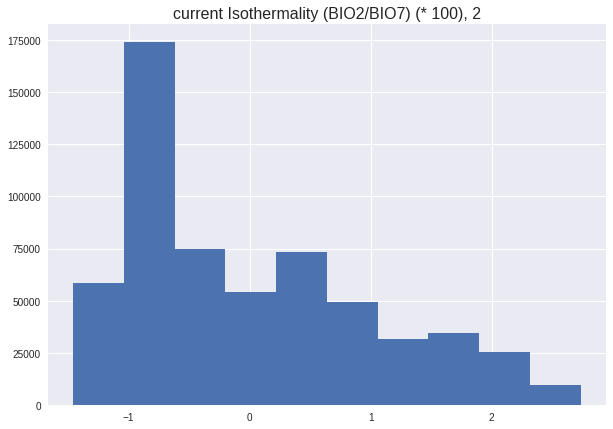

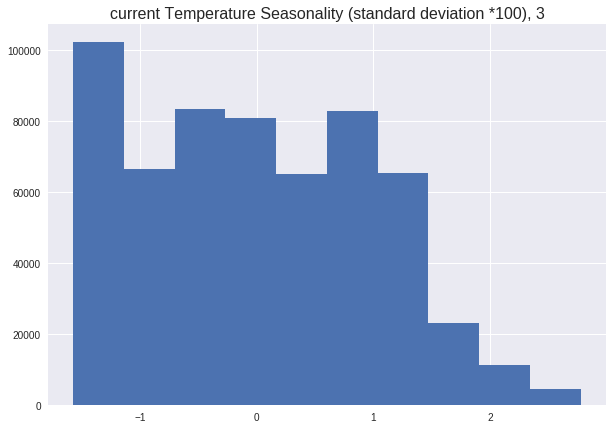

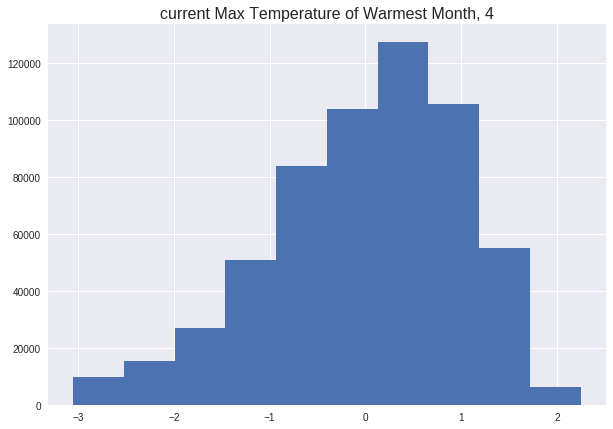

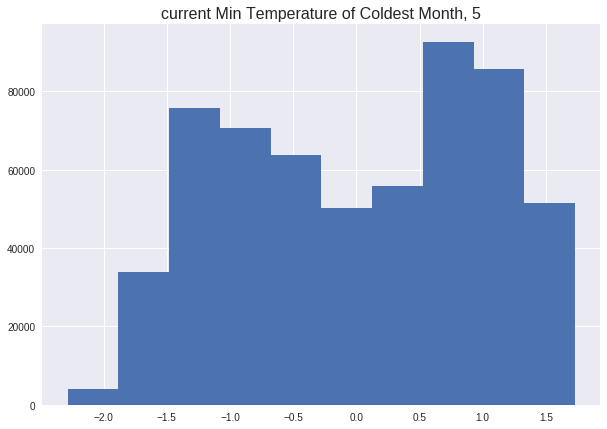

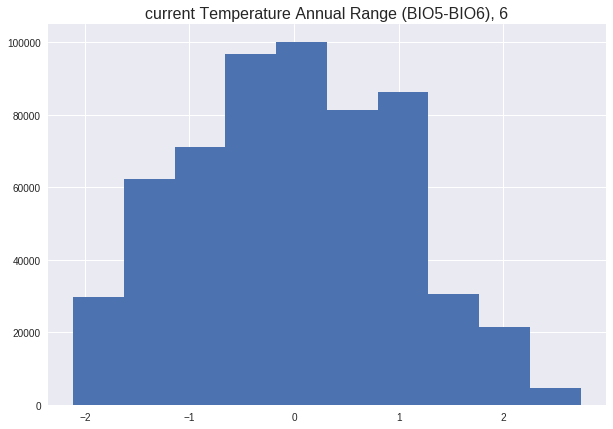

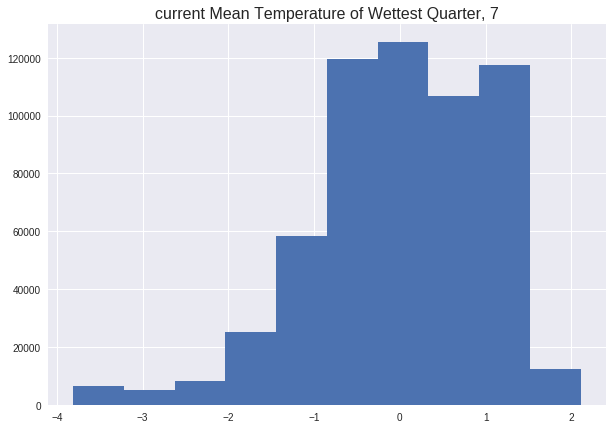

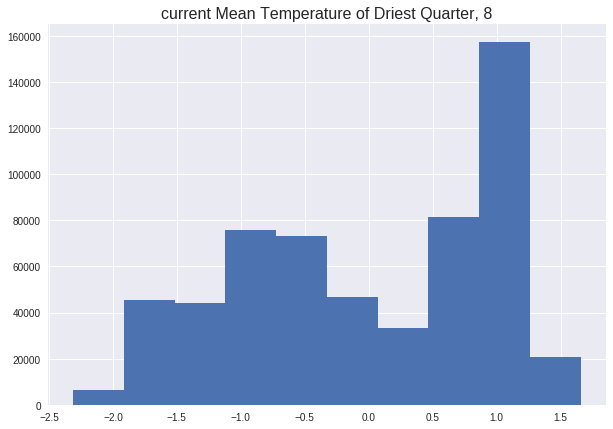

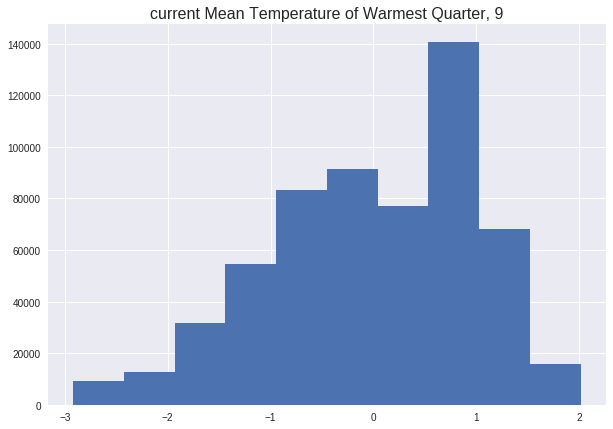

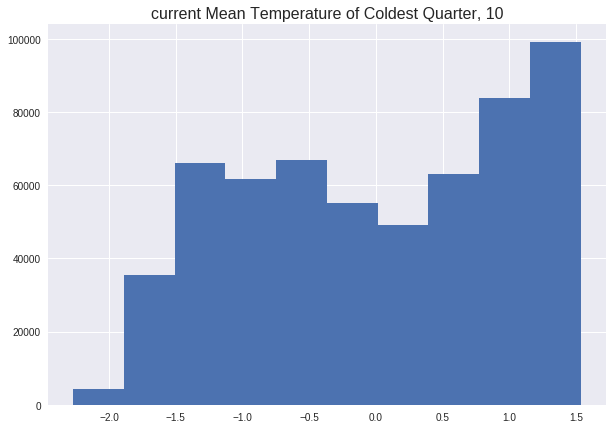

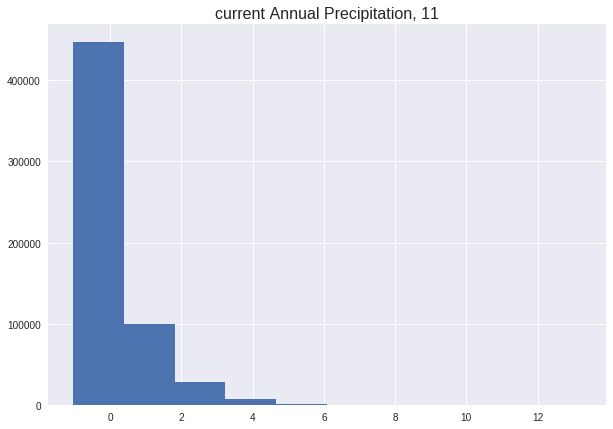

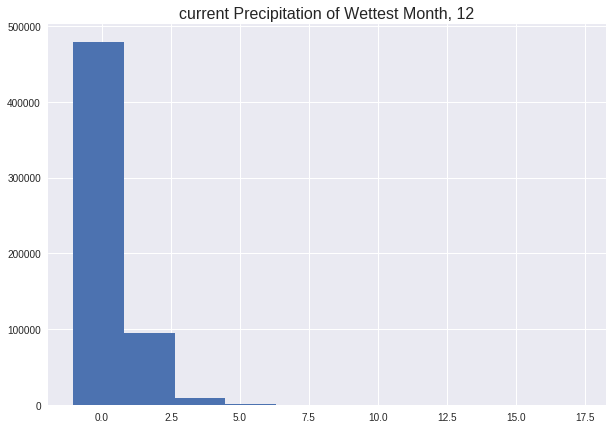

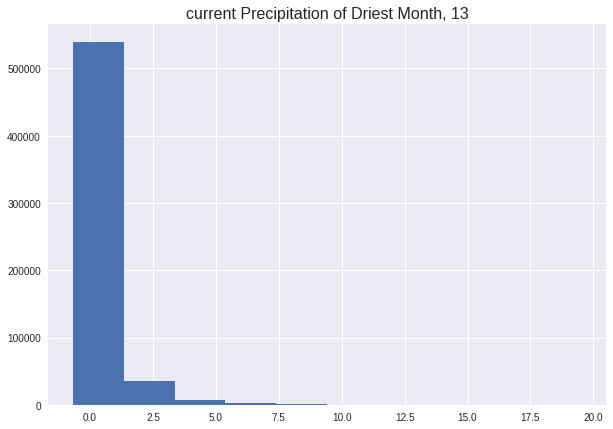

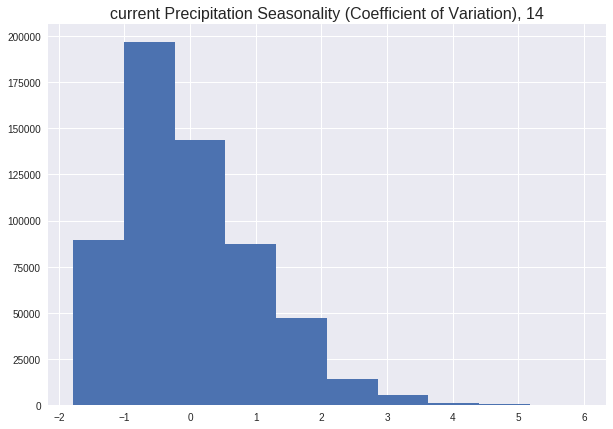

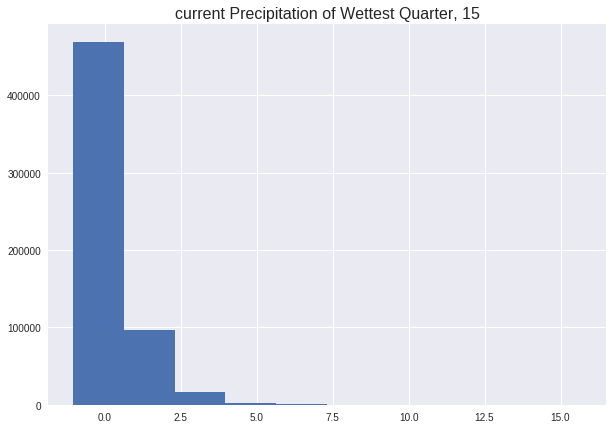

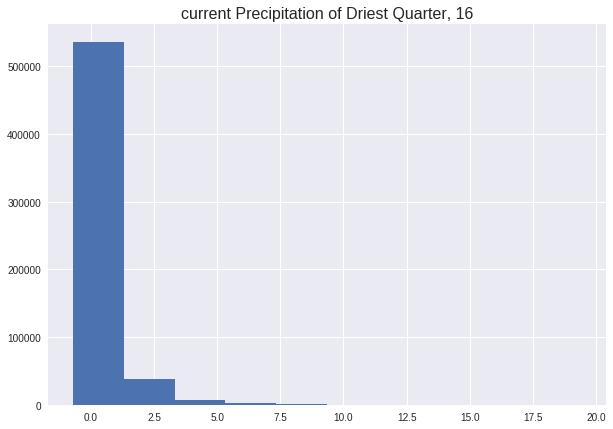

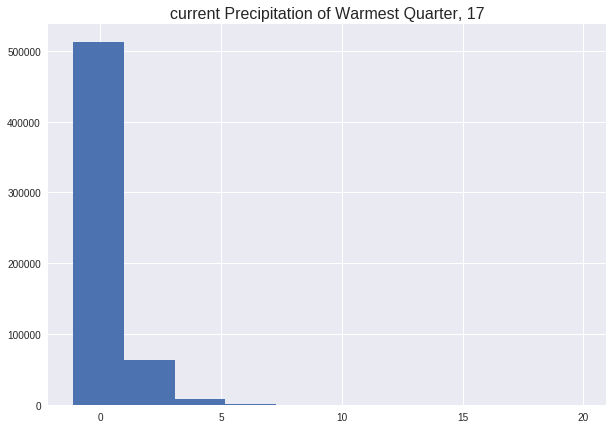

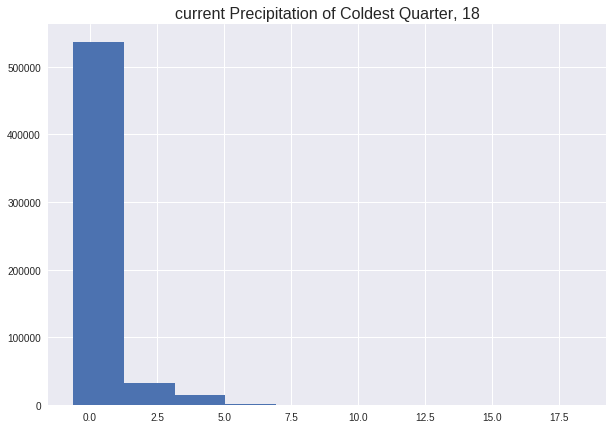

In [0]:
for i in range(19):
  plt.figure(figsize=(10,7))
  plt.hist(processed_current_observations[:,i])
  plt.title("current {}, {}".format(feature_names[i], i), fontsize=16)

## Clustering Data

Now let's try to generate some ecoregions on the current data using our features and then evaluating the future locations

In [0]:
def plot_cluster(labels, title=None, empty_raster=empty_raster):
  label_raster = empty_raster.copy()
  label_raster[~label_raster.mask] = labels
  plt.figure(figsize=(18,6))
  im = plt.imshow(label_raster, cmap='tab10', vmin=0, vmax=labels.max())
  plt.colorbar(im, fraction=0.046, pad=0.04)
  if title is not None:
    plt.title(title, fontsize=16)
  plt.grid("off")

In [0]:
from sklearn.cluster import MiniBatchKMeans

In [0]:
# let's initialize our clustering algorithm and ask it to group our grid cells into 10 clusters
kmeans = cluster.MiniBatchKMeans(n_clusters=10)

In [0]:
processed_current_observations.shape

(584521, 19)

Here we fit the kmeans model using the current bio indicators as well as the projected indicators under the bc2.6 model

In [0]:
%%time

# uncomment the training data setup that you want to investigate,
# training_data = processed_current_observations
training_data = np.concatenate([processed_current_observations, processed_projections["bc26bi50"]])
# training_data = np.concatenate([processed_current_observations, processed_projections["bc85bi50"]])
print("fitting model on {:,} data points".format(training_data.shape[0]))
kmeans.fit(training_data)
# uncomment to instead train on current observations and future projections
# kmeans.fit(np.concatenate([processed_current_observations, processed_projections["bc26bi50"]]))

fitting model on 1,169,042 data points
CPU times: user 3.41 s, sys: 27 ms, total: 3.43 s
Wall time: 3.44 s


Here we can find which clusters it assigned the current data, note that we could also get this from kmeans.labels_, which stores the labels of the data it trained on

In [0]:
current_labels = kmeans.predict(processed_current_observations)

As a first iteration we can check out how many grid squares the kmeans algorithm assigned to each cluster

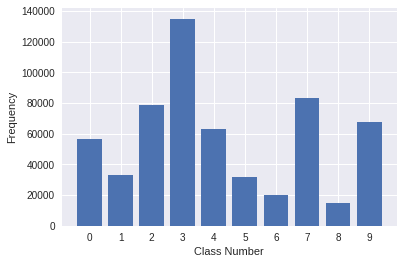

In [0]:
vals, counts = np.unique(current_labels, return_counts=True)
plt.figure()
plt.bar(range(len(vals)), counts)
plt.xticks(vals)
plt.xlabel("Class Number")
plt.ylabel("Frequency")
plt.show()
plt.close()

Here we can actually look at which clusters are where and try to get an intuition for how the model is behaving. Note that the x,y is not a feature here so nearby areas are not necessarily clustered with one another

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


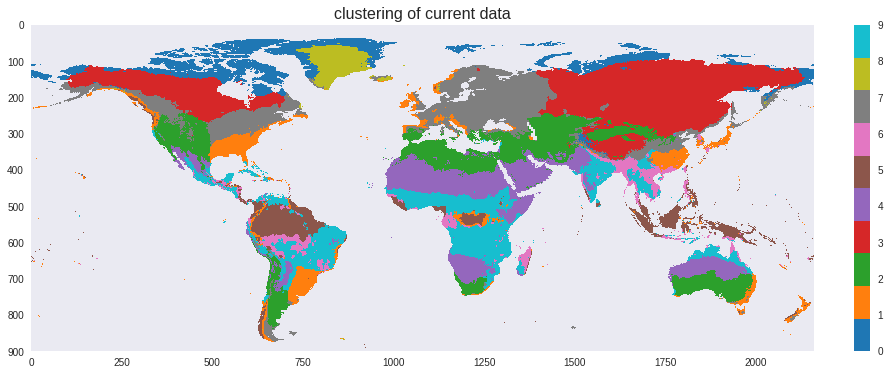

In [0]:
plot_cluster(current_labels, "clustering of current data")

In [0]:
projection_labels = {model: kmeans.predict(model_observations) 
                    for model, model_observations in processed_projections.items()}

Let's also take a look at how these regions change in the projected worst case and best case scenarios

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


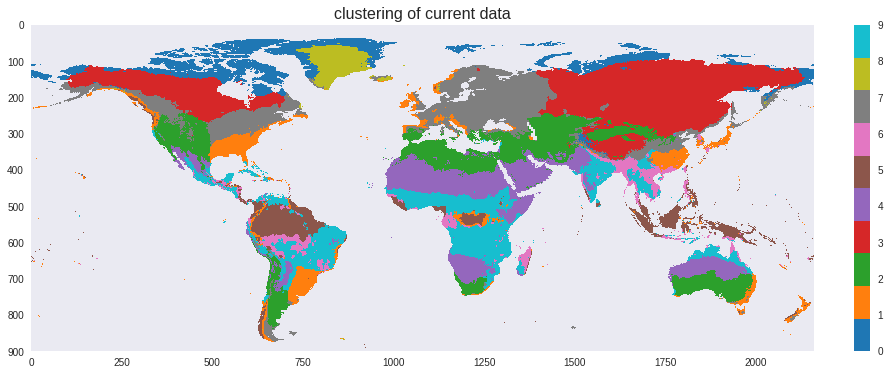

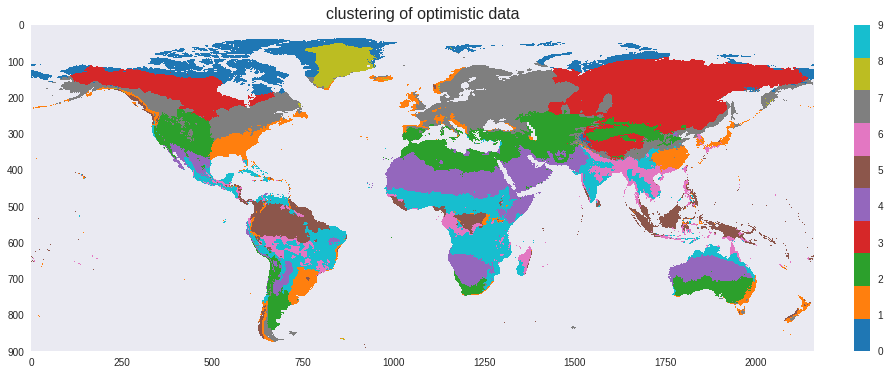

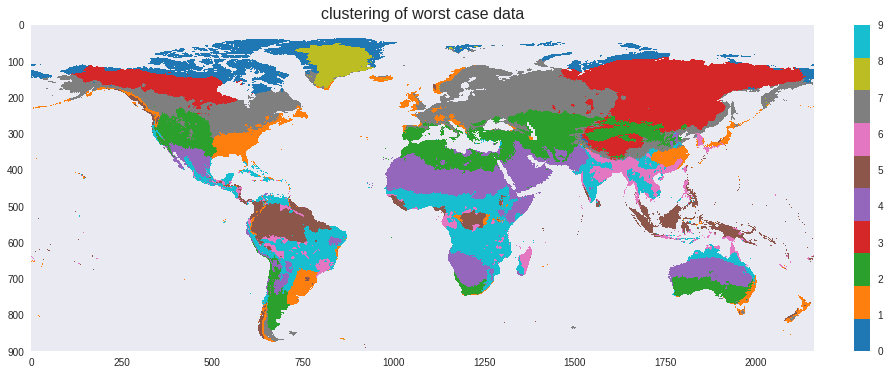

In [0]:
plot_cluster(current_labels, "clustering of current data")
plot_cluster(projection_labels["bc26bi50"], title="clustering of optimistic data")
plot_cluster(projection_labels["bc85bi50"], title="clustering of worst case data")

## Analyzing Clusters

Alaska slice
100:250,:300

### Centroids

Let's take a look at the cluster centroids to have a better understanding of what these clusters represent.

Looking at the shape of the cluster centers field, we can see that there is 1 row for each cluster and 19 features in that cluster center.

In [0]:
def describe_cluster_centers(clustering, feature_names=feature_names):
  max_val = kmeans.cluster_centers_.max()
  min_val = kmeans.cluster_centers_.min()
  for label, centroid in enumerate(clustering.cluster_centers_):
    plt.figure(figsize=(18,6))
    plt.barh(feature_names, centroid,color=matplotlib.cm.tab20.colors)
    plt.xlim(min_val,max_val)
    plt.title("cluster {}".format(label))

Now let's plot the cluster centers. Remember that since we did normalization of the raw indicators, the values represent slightly different values. In this case, a value of 0 indicates that the feature is at around the average value among all our data. A very negative value means that this is an extraordinarily low value, and a very positive value means that this is a very high value. See if you can look at some of the clusters and give them some semantic meaning (so that we can explain our clusters).

Remember to keep in mind that these centroids are by definition the "average" point among all points in that class so these should describe the relevant cluster.

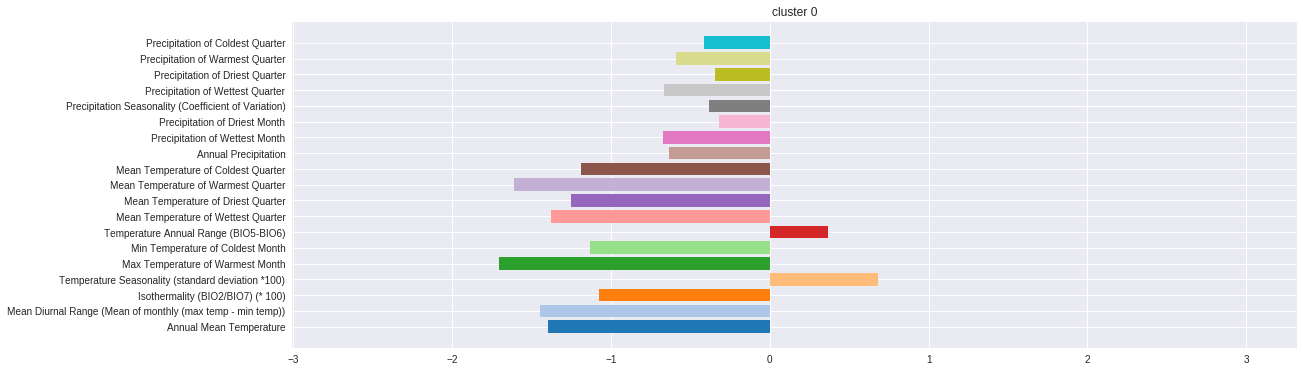

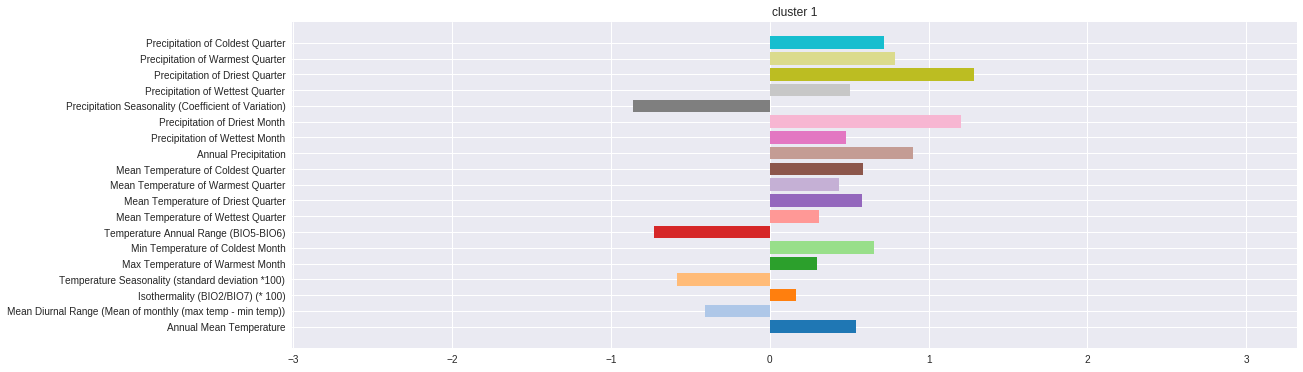

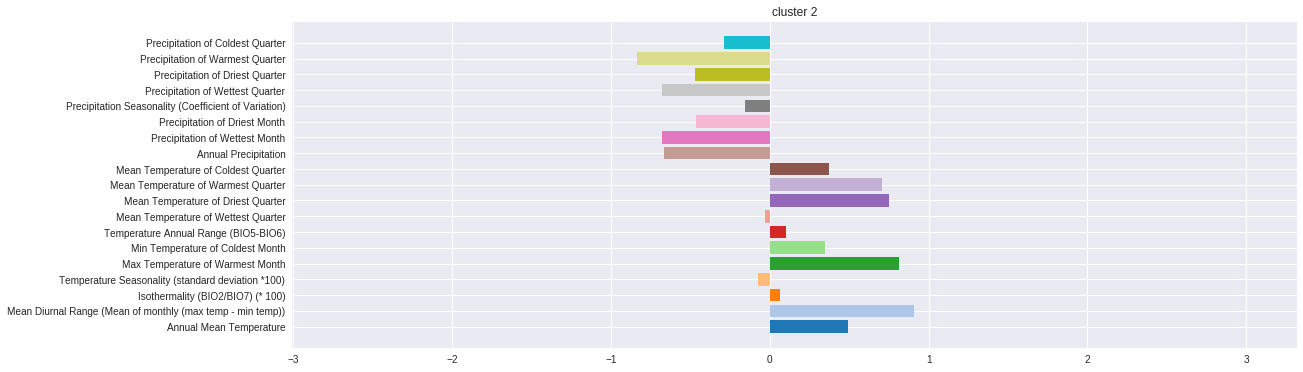

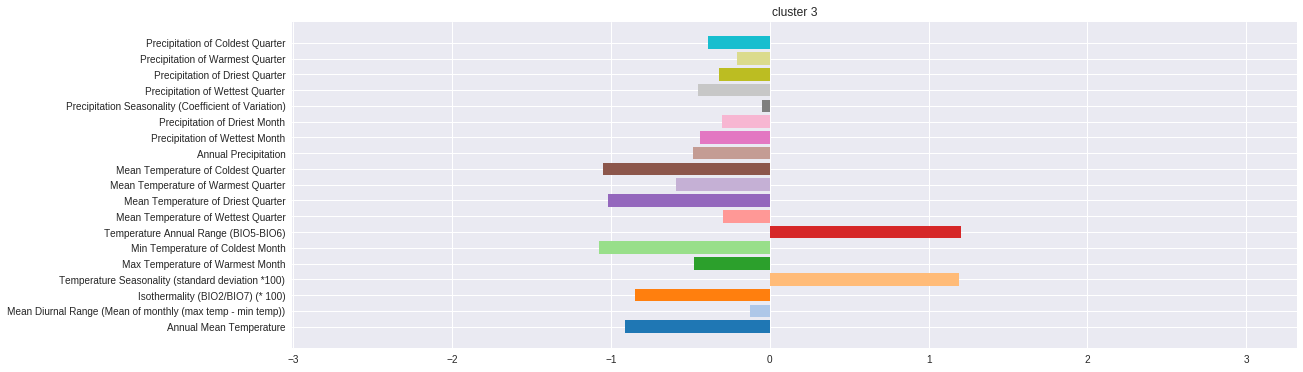

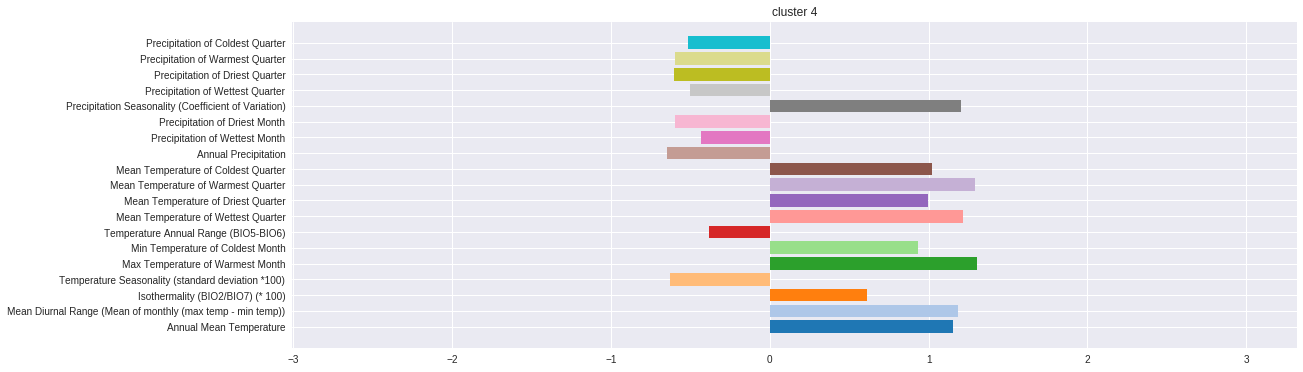

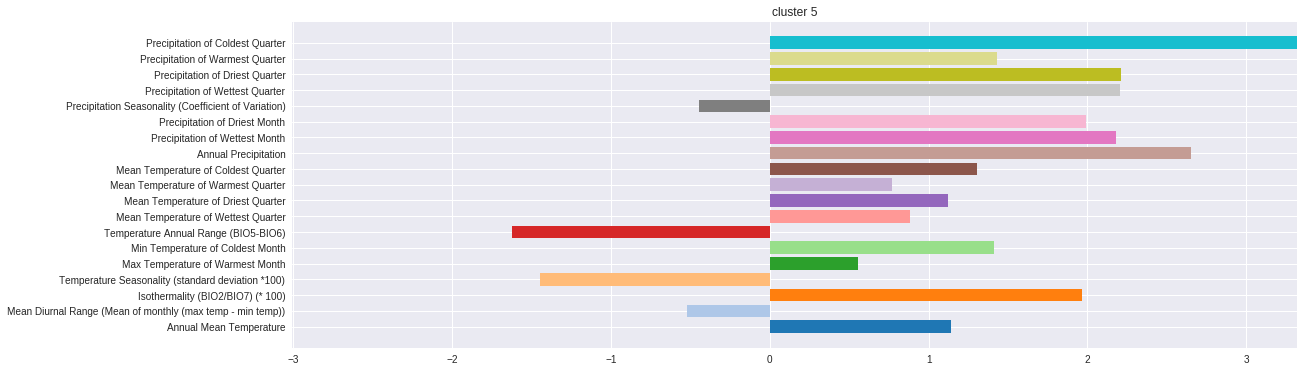

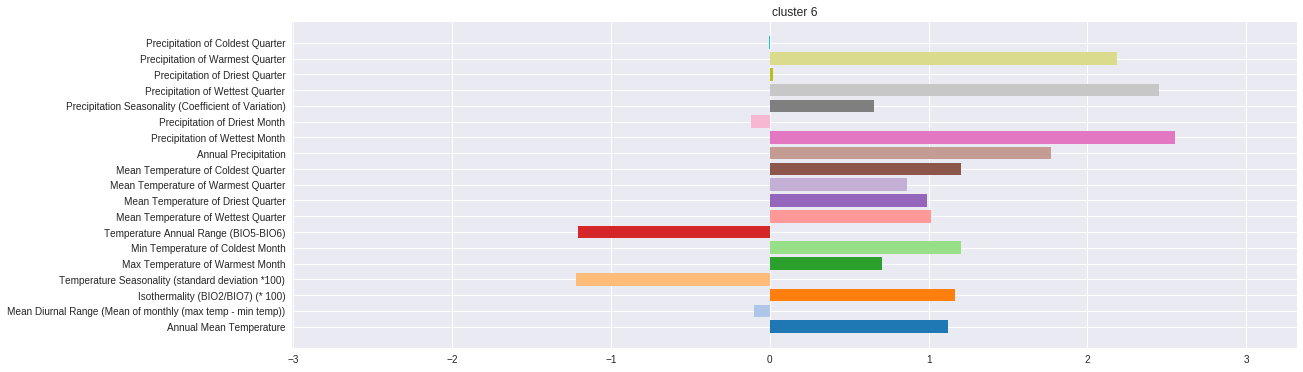

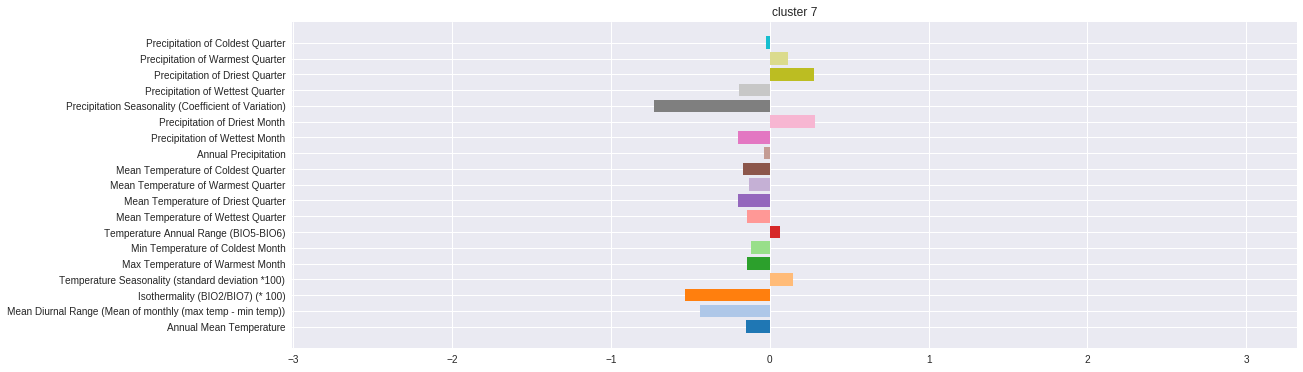

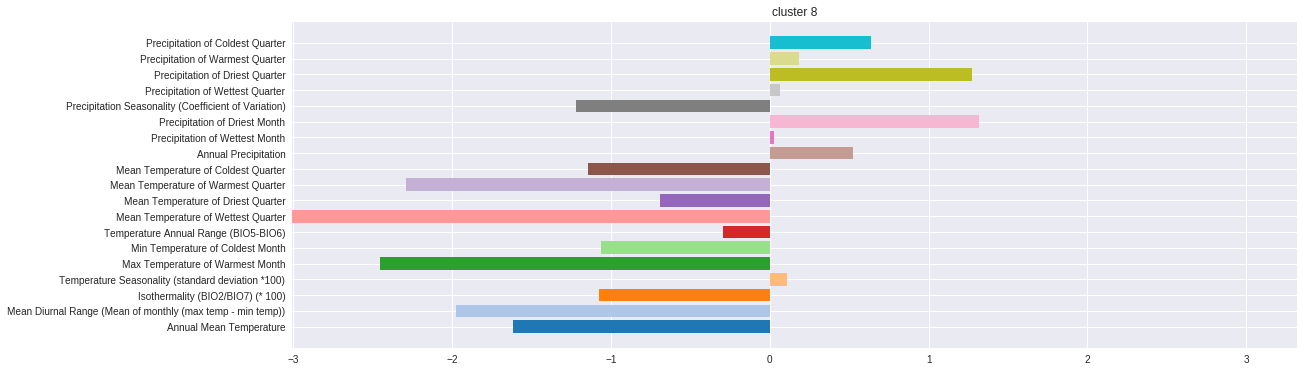

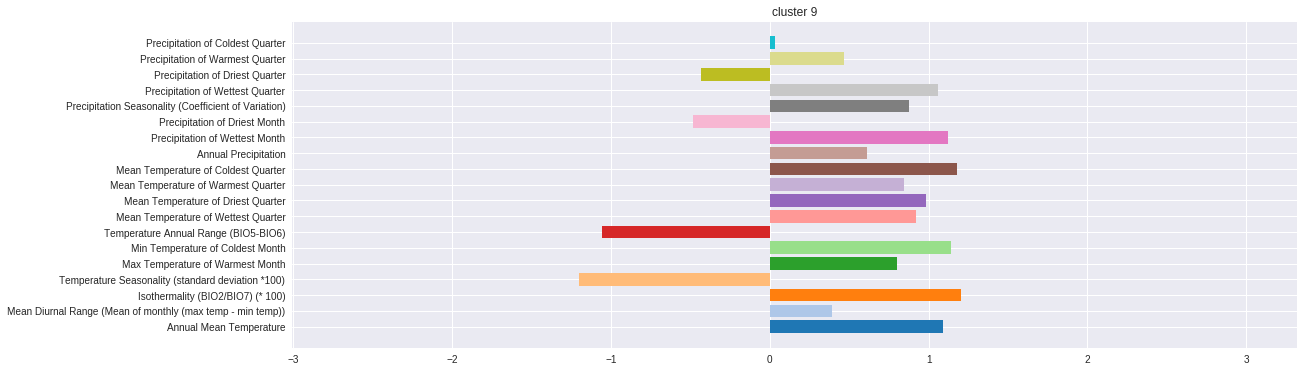

In [0]:
describe_cluster_centers(kmeans)

In [0]:
def plot_centroid_distances(data, title=None, empty_raster=empty_raster):
  data_raster = empty_raster.copy()
  data_raster[~data_raster.mask] = data
  plt.figure(figsize=(18,6))
  im = plt.imshow(data_raster, cmap='Reds', vmin=0, vmax=4)
  plt.colorbar(im, fraction=0.046, pad=0.04)
  if title is not None:
    plt.title(title, fontsize=16)
  plt.grid("off")

Let's look at the distance from points in a cluster to the cluster centroid.

For each cluster we can check how far away it is from it's centroid using a distance metric, in this case the euclidean distance.

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


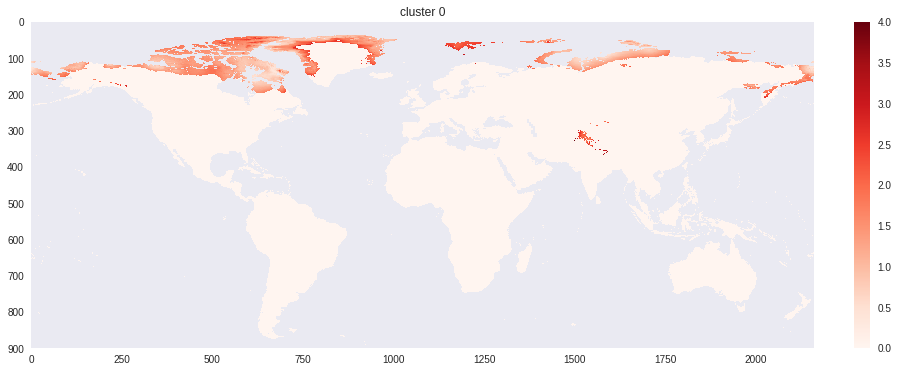

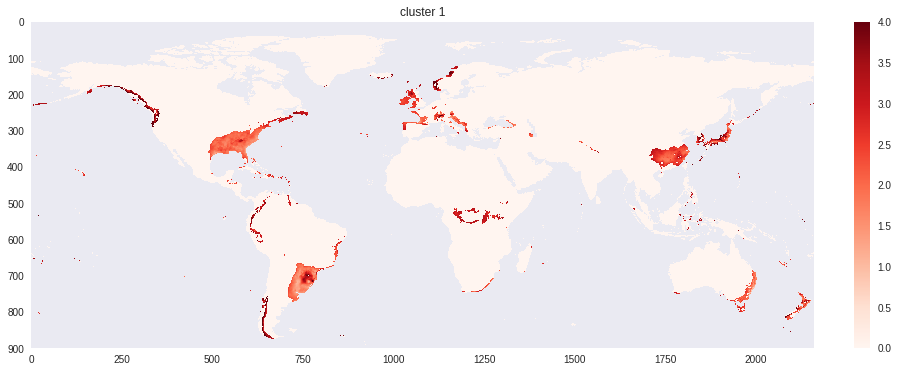

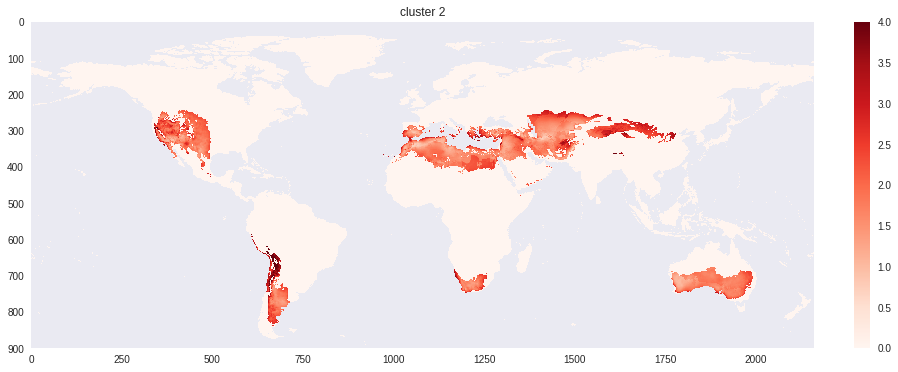

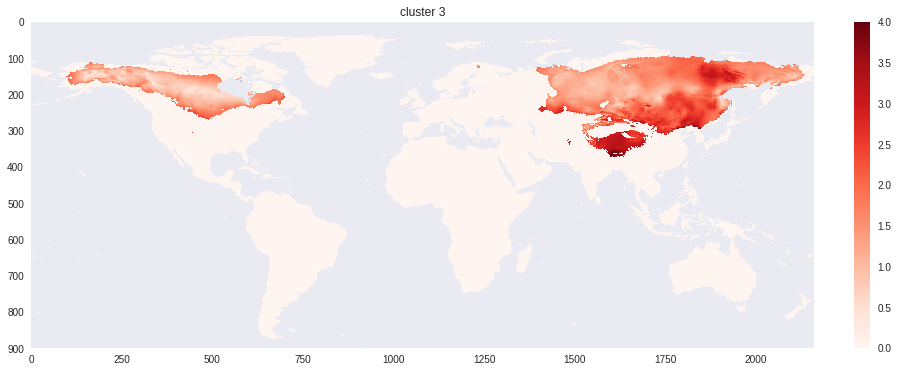

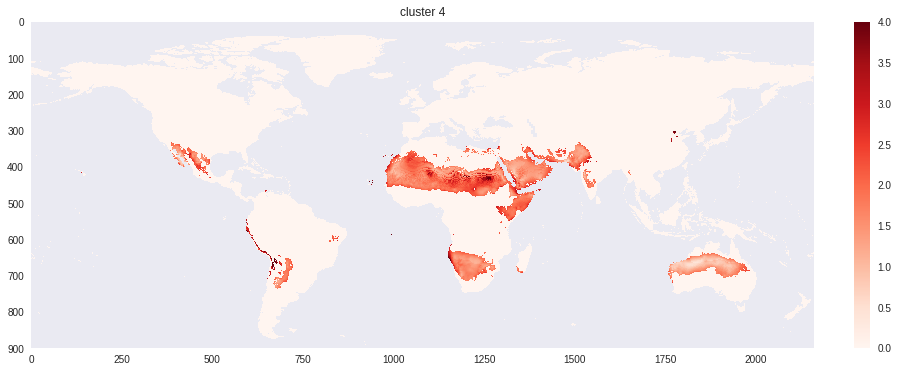

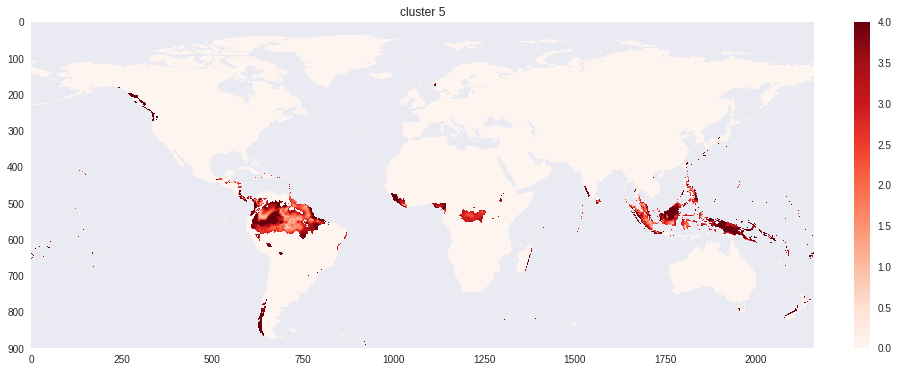

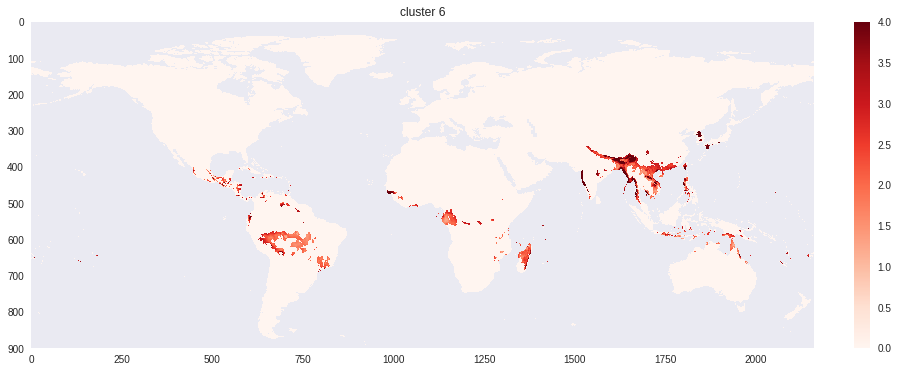

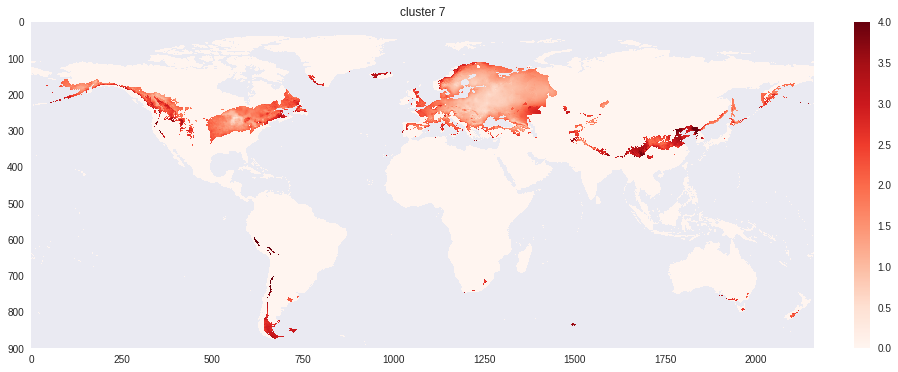

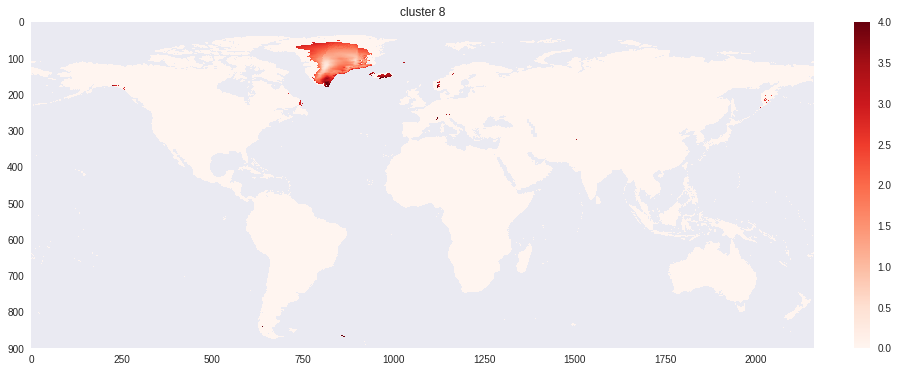

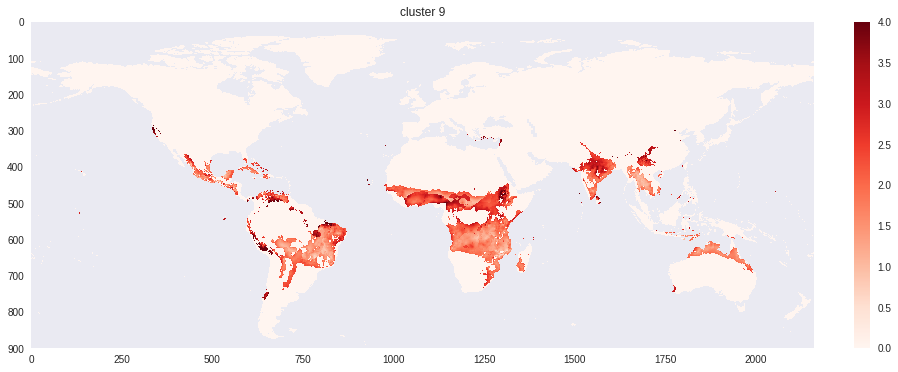

In [0]:
for label, centroid in enumerate(kmeans.cluster_centers_):
  distance_to_centroids = np.zeros((processed_current_observations.shape[0],))
  label_inds = current_labels == label
  #distance_to_centroids[label_inds] = np.linalg.norm(processed_current_observations[label_inds,:] - centroid, axis=1)
  distance_to_centroids[label_inds] = scipy.spatial.distance.cdist(processed_current_observations[label_inds,:], centroid.reshape(1,-1), metric='euclidean')[:,0]
  plot_centroid_distances(distance_to_centroids)
  plt.title("cluster {}".format(label))

### Sum of Squared Error (SSE)
Here let's take a look at the total sum of squared errors to the centroids as a test of how good our model is at clustering the grid squares

In [0]:
def compute_sse(data, labels, centroids):
  SSE = 0
  for label, centroid in enumerate(centroids):
    label_inds = labels == label
    instance_distances = (data[label_inds,:] - centroid) ** 2.0
    SSE += instance_distances.sum()
  return SSE

In [0]:
SSE = compute_sse(processed_current_observations, current_labels, kmeans.cluster_centers_)
print("SSE",SSE)

SSE 2759445.5078125


### Sillouhette Score

https://scikit-learn.org/stable/modules/clustering.html

In [0]:
silhouette_score = metrics.silhouette_score(processed_current_observations, current_labels, sample_size=7000)

In [0]:
print("silhouette score:",silhouette_score)

silhouette score: 0.23579915


### Sensitivity to Number of Clusters

In [0]:
k_range = range(2,30,2)
classifiers = {}
classifier_labels = {}
silhouette_scores = {}
SSE_scores = {}
for k in k_range:
  classifiers[k] = cluster.MiniBatchKMeans(n_clusters=k)
  classifier_labels[k] = classifiers[k].fit_predict(training_data)
  silhouette_scores[k] = metrics.silhouette_score(training_data, classifier_labels[k], sample_size=7000)
  SSE_scores[k] = compute_sse(training_data, classifier_labels[k], classifiers[k].cluster_centers_)
  print("num clusters:{}, SSE:{}, silhouette score:{}".format(k,SSE_scores[k], silhouette_scores[k]))
  

num clusters:2, SSE:13997731.5, silhouette score:0.3562702238559723
num clusters:3, SSE:10408247.75, silhouette score:0.3584418296813965
num clusters:4, SSE:9176210.125, silhouette score:0.2874908745288849
num clusters:5, SSE:7784161.625, silhouette score:0.2643145024776459
num clusters:6, SSE:7524009.75, silhouette score:0.21895919740200043
num clusters:7, SSE:7105892.375, silhouette score:0.2177409827709198
num clusters:8, SSE:6100170.46875, silhouette score:0.23585782945156097
num clusters:9, SSE:5826700.375, silhouette score:0.22831562161445618
num clusters:10, SSE:5478368.28125, silhouette score:0.2404029369354248
num clusters:11, SSE:5187635.5859375, silhouette score:0.2449980527162552
num clusters:12, SSE:5024202.890625, silhouette score:0.21500170230865479
num clusters:13, SSE:5283786.9296875, silhouette score:0.2092166244983673
num clusters:14, SSE:4487174.5546875, silhouette score:0.22921967506408691
num clusters:15, SSE:4398094.9765625, silhouette score:0.2231685221195221
nu

Here we can plot the SSE and silhouette scores to visualize how they vary with the number of clusters

Text(0.5, 1.0, 'Silhouette score vs number of clusters')

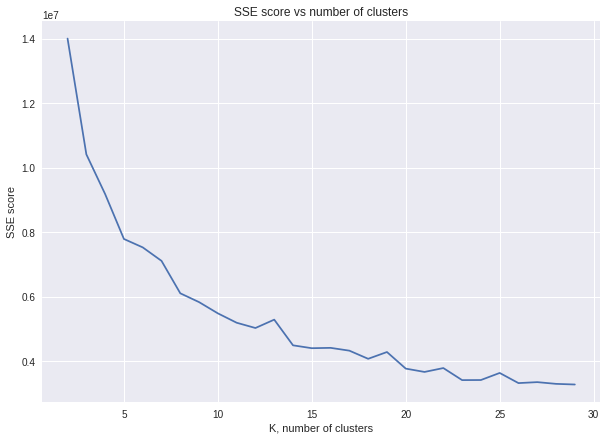

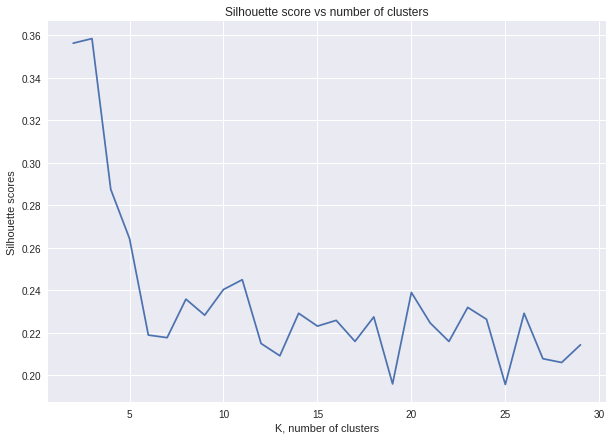

In [0]:
plt.figure(figsize=(10,7))
plt.plot(k_range, [SSE_scores[k] for k in k_range])
plt.xlabel("K, number of clusters")
plt.ylabel("SSE score")
plt.title("SSE score vs number of clusters")

plt.figure(figsize=(10,7))
plt.plot(k_range, [silhouette_scores[k] for k in k_range])
plt.xlabel("K, number of clusters")
plt.ylabel("Silhouette scores")
plt.title("Silhouette score vs number of clusters")

### Sensitivity to Initial Centroids

In [0]:
best_classifier = None
best_sse = -1
best_index = -1
for i in range(15):
  classifier = cluster.MiniBatchKMeans(n_clusters=10)
  random_init_classifier_labels = classifier.fit_predict(training_data)
  silhouette_scores[i] = metrics.silhouette_score(training_data, random_init_classifier_labels, sample_size=5000)
  SSE_scores[i] = compute_sse(training_data, random_init_classifier_labels, classifier.cluster_centers_)
  if SSE_scores[i] > best_sse:
    best_classifier = classifier
    best_sse = SSE_scores[i]
    best_index = i
  print("iteration:{}, SSE:{}, silhouette score:{}".format(i,SSE_scores[i], silhouette_scores[i]))
print("best sse:{}, best_index:{}".format(best_sse, best_index))

iteration:0, SSE:5530985.703125, silhouette score:0.24421580135822296
iteration:1, SSE:5625574.8125, silhouette score:0.21241970360279083
iteration:2, SSE:5648270.6875, silhouette score:0.21327190101146698
iteration:3, SSE:5431426.4375, silhouette score:0.22886396944522858
iteration:4, SSE:5812368.6328125, silhouette score:0.23292773962020874
iteration:5, SSE:5693585.375, silhouette score:0.21413256227970123
iteration:6, SSE:5496213.9375, silhouette score:0.2238587886095047
iteration:7, SSE:5579214.90625, silhouette score:0.23143166303634644
iteration:8, SSE:5673016.84375, silhouette score:0.21368737518787384
iteration:9, SSE:5855513.609375, silhouette score:0.19091977179050446
iteration:10, SSE:5590874.140625, silhouette score:0.24000854790210724
iteration:11, SSE:5587220.859375, silhouette score:0.19865627586841583
iteration:12, SSE:5716874.9375, silhouette score:0.2346198707818985
iteration:13, SSE:5506713.546875, silhouette score:0.2531013786792755
iteration:14, SSE:5534972.71875, 

Text(0.5, 1.0, 'Silhouette score histogram for 10 clusters')

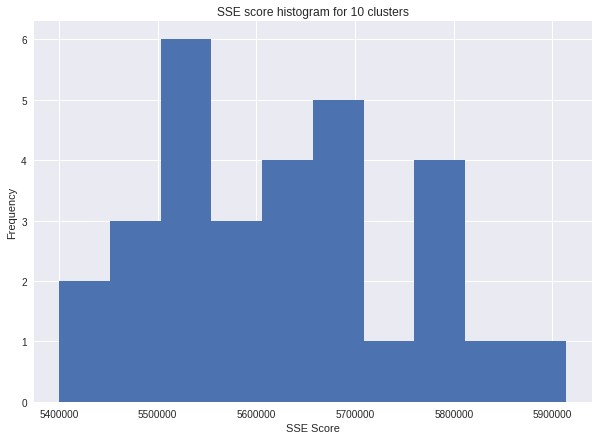

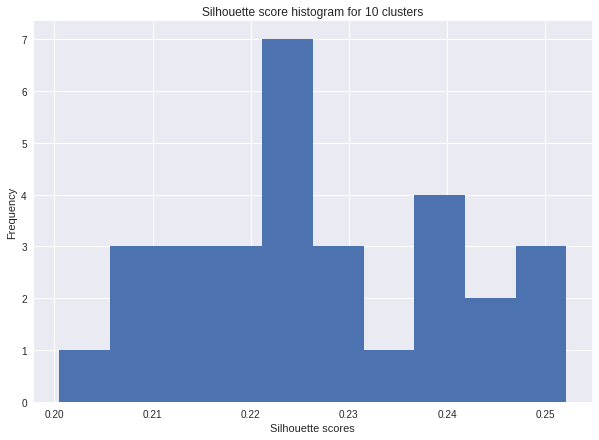

In [0]:
plt.figure(figsize=(10,7))
plt.hist(SSE_scores.values())
plt.xlabel("SSE Score")
plt.ylabel("Frequency")
plt.title("SSE score histogram for 10 clusters")

plt.figure(figsize=(10,7))
plt.hist(silhouette_scores.values())
plt.xlabel("Silhouette scores")
plt.ylabel("Frequency")
plt.title("Silhouette score histogram for 10 clusters")

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


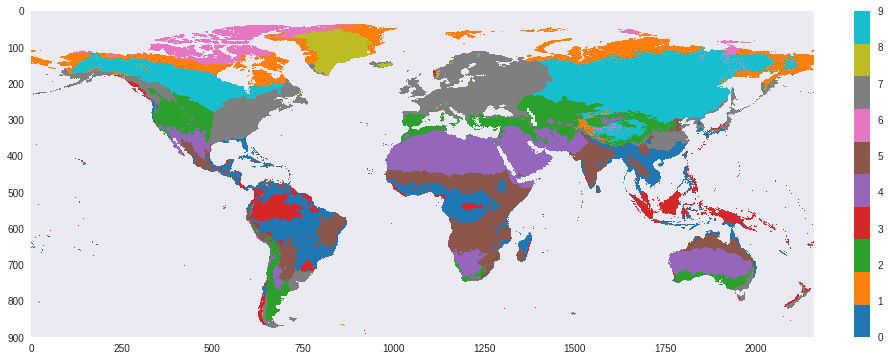

In [0]:
best_labels = best_classifier.predict(processed_current_observations)
plot_cluster(best_labels)

## Implementations + Next Steps
Try to see if you can implement some of the core ml features on your own. You will develop better intution for how these algorithms and metrics work and when they can go wrong. 


### Kmeans

In [0]:
# TO IMPLEMENT
class KMeans_499(object):
  def __init__(self, nclusters, ):
    # initialize itnernal datastructures
    pass
  
  def fit(self, X,):
    # fit kmeans model (find centroids iteratively)
    pass
  
  def predict(self, X,):
    # predict labels for the given input data
    pass

### Silhouette Score

In [0]:
def silhouette_score(data, labels):
  pass

### Other clustering techniques


Also try out other clustering techniques from here: https://scikit-learn.org/stable/modules/clustering.html such as hierarchical clustering or something like dbscan. Which work? Which take too long? Do any require more hyperparameters such as kernels?